In [1]:
import Pkg
# Pkg.add("Optim")
# Pkg.add("Plots")
# Pkg.add("NLopt")
# Pkg.add(["CSV", "HTTP", "DataFrames", "Dates", "Statistics", "Plots"])

In [2]:
using LinearAlgebra
using NLopt
using Plots

function gpr_predict(xB::Vector{Float64}, yB::Vector{Float64}; xPred=nothing, plot_result=true)

    # Função objetivo (log-verossimilhança negativa)
    function objective(x::Vector, grad::Vector)
        c2, c1, c0, sigmaF2, ell, sigmaN2, c4, c3 = x
        mxB = c4 .* xB.^4 .+ c3 .* xB.^3 .+ c2 .* xB.^2 .+ c1 .* xB .+ c0
        n = length(xB)
        KB = zeros(n, n)
        for i in 1:n
            for j in i:n
                noise = (i == j) ? sigmaN2^2 : 0.0
                k = sigmaF2^2 * exp(-((xB[i] - xB[j])^2) / (2 * ell^2)) + noise
                KB[i,j] = k
                KB[j,i] = k
            end
        end
        # Estabilidade numérica: checa Cholesky
        try
            cholesky(Symmetric(KB))
        catch
            return 1e10
        end
        KBinv = inv(KB)
        diff = yB .- mxB
        term1 = -0.5 * logdet(KB)
        term2 = -0.5 * (diff' * KBinv * diff)[1]
        term3 = -n/2 * log(2π)
        return -(term1 + term2 + term3)
    end

    # Configura o otimizador COBYLA
    opt = Opt(:LN_COBYLA, 8)
    lower_bounds!(opt, [-10.0, -10.0, -10.0, 0.8, 1.0, 1e-5, -10.0, -10.0])
    upper_bounds!(opt, [ 10.0,  10.0,  10.0, 5.0, 5.0, 1.0,   10.0,  10.0])
    xtol_rel!(opt, 1e-6)
    maxeval!(opt, 2000)
    min_objective!(opt, objective)

    # Valores iniciais (idênticos ao Python)
    x0 = [0.1, 0.01, 0.01, 2.0, 1.0, 0.01, 0.01, 0.01]

    # Executa otimização
    minf, xopt, ret = NLopt.optimize(opt, x0)

    # Hiperparâmetros aprendidos
    c2, c1, c0, sigmaF2, ell, sigmaN2, c4, c3 = xopt

    # Funções de média e covariância
    priormean(x) = c4 .* x.^4 .+ c3 .* x.^3 .+ c2 .* x.^2 .+ c1 .* x .+ c0
    corrFunc(xa, xb) = sigmaF2^2 * exp(-((xa - xb)^2) / (2 * ell^2))

    # Domínio de predição
    if xPred === nothing
        xPred = 0:0.2:10
    end

    nB = length(xB)
    nPred = length(xPred)

    # Matriz KB (covariância dos dados)
    KB = zeros(nB, nB)
    for i in 1:nB
        for j in i:nB
            noise = (i == j) ? sigmaN2^2 : 0.0
            k = corrFunc(xB[i], xB[j]) + noise
            KB[i,j] = k
            KB[j,i] = k
        end
    end
    KBinv = inv(KB)

    # Ks: covariância entre predição e treino
    Ks = [corrFunc(xp, xb) for xp in xPred, xb in xB]

    # Kss: covariância entre pontos de predição
    Kss = [corrFunc(xi, xj) + (i == j ? sigmaN2^2 : 0.0)
           for (i, xi) in enumerate(xPred), (j, xj) in enumerate(xPred)]

    # Média e variância preditiva
    mxB = priormean(xB)
    mus = priormean(xPred)
    ypred = mus + Ks * KBinv * (yB - mxB)
    yvar = diag(Kss - Ks * KBinv * Ks')
    stds = sqrt.(max.(yvar, 0.0))

    # Plot semelhante ao Python
    if plot_result
        x = 0:0.1:10
        mx = priormean(x)
        plt = plot(x, mx, label="mean m(x)", lw=2, legend=:topright)
        scatter!(xB, yB, label="training data", color=:red)
        plot!(xPred, ypred, linestyle=:dash, color=:green, label="predictions")
        plot!(xPred, ypred, ribbon=2*stds, fillalpha=0.3, label="95% CI", color=:green)
        xlabel!("x")
        ylabel!("f(x)")
        title!("Gaussian Process Prediction with Bi-quadratic Mean")
        default(grid = true)
        display(plt)
    end

    return xPred, ypred, stds
end


gpr_predict (generic function with 1 method)

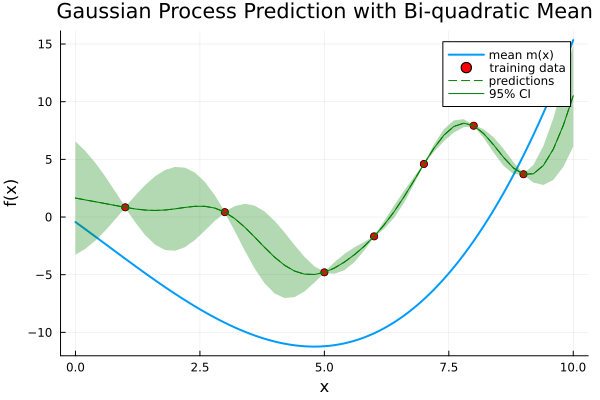

(0.0:0.2:10.0, [1.6459557516662626, 1.481728108423786, 1.3252839588616534, 1.1663798177206552, 1.002459451026592, 0.8413539688460232, 0.7007267272681084, 0.6035467075776415, 0.5701583304200275, 0.6089057916149567  …  7.237586496029013, 6.251416176895295, 5.170968188018736, 4.244647758965836, 3.7094835014753587, 3.750198477998297, 4.471730396250052, 5.890640154766566, 7.945258141466956, 10.519533004688732], [2.4549315462987296, 2.116171581072484, 1.684687837708469, 1.170567259782061, 0.59749301483463, 0.026369015053736997, 0.5771346456207425, 1.0861327407359844, 1.4841197523497052, 1.7353927159981748  …  0.19032635255369193, 0.3308376112340485, 0.36582969582973396, 0.25834588047164975, 0.026368787758702807, 0.38400749964187075, 0.8469750680662379, 1.3363459492902527, 1.800831337586902, 2.2024024904931703])

In [3]:
xB = [1., 3., 5., 6., 7., 8., 9.]
yB = xB .* sin.(xB)

xPred, yPred, stds = gpr_predict(xB, yB; plot_result=true)

In [1]:
using LinearAlgebra
using Statistics
using NLopt
using Plots

function gpr_predict_multidim(XB::Matrix{Float64}, yB::Vector{Float64}; XPred=nothing, plot_result=true)
    XB = convert(Matrix{Float64}, XB)
    n_samples, n_features = size(XB)

    # Normalização de entrada
    X_mean = mean(XB, dims=1)
    X_std = std(XB, dims=1)
    XB_scaled = (XB .- X_mean) ./ X_std

    # Centralização da saída
    y_mean = mean(yB)
    y_centered = yB .- y_mean

    # Normaliza XPred (ou gera malha 2D)
    if XPred === nothing
        x1 = range(-2, 2, length=50)
        x2 = range(-2, 2, length=50)
        X1 = repeat(x1, inner=50)
        X2 = repeat(x2, outer=50)
        XPred = hcat(X1, X2)  # salva XPred original como escala normalizada
    end

    XPred = convert(Matrix{Float64}, XPred)
    XPred_scaled = (XPred .- X_mean) ./ X_std

    # Média linear
    priormean(X, w, b) = X * w .+ b

    # Kernel RBF isotrópico
    function corrFunc(xa::AbstractVector, xb::AbstractVector, sigmaF2, ell)
        d = sum((xa .- xb).^2)
        return sigmaF2^2 * exp(-d / (2 * ell^2))
    end

    # Função objetivo
    function objective(x::Vector, grad)
        w = x[1:n_features]
        b = x[n_features + 1]
        sigmaF2 = x[n_features + 2]
        ell     = x[n_features + 3]
        sigmaN2 = x[n_features + 4]
        mxB = priormean(XB_scaled, w, b)
        KB = zeros(n_samples, n_samples)
        for i in 1:n_samples
            for j in i:n_samples
                k = corrFunc(view(XB_scaled, i, :), view(XB_scaled, j, :), sigmaF2, ell)
                if i == j
                    k += sigmaN2^2 + 1e-8
                end
                KB[i,j] = KB[j,i] = k
            end
        end
        try
            cholesky(Symmetric(KB))
        catch
            return 1e10
        end
        KBinv = inv(KB)
        diff = y_centered .- mxB
        term1 = -0.5 * logdet(KB)
        term2 = -0.5 * dot(diff, KBinv * diff)
        term3 = -n_samples / 2 * log(2π)
        return -(term1 + term2 + term3)
    end

    # Otimização (NLopt)
    opt = Opt(:LN_COBYLA, n_features + 4)
    lower_bounds!(opt, fill(-10.0, n_features + 4))
    upper_bounds!(opt, fill(10.0, n_features + 4))

    lb = lower_bounds(opt)
    ub = upper_bounds(opt)

    lb[n_features + 2] = 0.8
    lb[n_features + 3] = 1.0
    ub[n_features + 3] = 5.0
    lb[n_features + 4] = 1e-5

    lower_bounds!(opt, lb)
    upper_bounds!(opt, ub)

    xtol_rel!(opt, 1e-6)
    maxeval!(opt, 2000)
    min_objective!(opt, objective)

    x0 = fill(0.1, n_features + 4)
    x0[n_features + 2] = 2.0
    x0[n_features + 3] = 1.0
    x0[n_features + 4] = 0.1

    (minf, xopt, ret) = optimize(opt, x0)

    w = xopt[1:n_features]
    b = xopt[n_features + 1]
    sigmaF2 = xopt[n_features + 2]
    ell     = xopt[n_features + 3]
    sigmaN2 = xopt[n_features + 4]

    mxB = priormean(XB_scaled, w, b)

    KB = zeros(n_samples, n_samples)
    for i in 1:n_samples
        for j in i:n_samples
            k = corrFunc(view(XB_scaled, i, :), view(XB_scaled, j, :), sigmaF2, ell)
            if i == j
                k += sigmaN2^2 + 1e-8
            end
            KB[i,j] = KB[j,i] = k
        end
    end
    KBinv = inv(KB)

    Ks = [corrFunc(view(xp, :), view(xb, :), sigmaF2, ell)
          for xp in eachrow(XPred_scaled), xb in eachrow(XB_scaled)]
    Ks = reshape(Ks, size(XPred_scaled, 1), n_samples)
    mus = priormean(XPred_scaled, w, b)

    ypred_centered = mus + Ks * KBinv * y_centered
    ypred = ypred_centered .+ y_mean

    Kss = [corrFunc(view(x1, :), view(x2, :), sigmaF2, ell) +
           (i == j ? sigmaN2^2 : 0.0)
           for (i, x1) in enumerate(eachrow(XPred_scaled)),
               (j, x2) in enumerate(eachrow(XPred_scaled))]
    Kss = reshape(Kss, size(XPred_scaled, 1), size(XPred_scaled, 1))
    yvar = diag(Kss - Ks * KBinv * Ks')
    stds = sqrt.(max.(yvar, 0.0))

    # Plot 2D (caso com 2 variáveis)
    if plot_result && n_features == 2
        x1_grid = reshape(XPred[:, 1], 50, 50)
        x2_grid = reshape(XPred[:, 2], 50, 50)
        y_grid = reshape(ypred, 50, 50)
        plt = contourf(x1_grid, x2_grid, y_grid, c=:viridis)
        scatter!(XB[:, 1], XB[:, 2], c=yB, markerstrokecolor=:black,
                 markerstrokewidth=0.5, label="Training")
        colorbar!(label="Prediction")
        title!("Gaussian Process Regression (2D)")
        xlabel!("x₁")
        ylabel!("x₂")
        display(plt)
    end

    return XPred, ypred, stds  # <-- XPred agora está na escala original!
end


gpr_predict_multidim (generic function with 1 method)

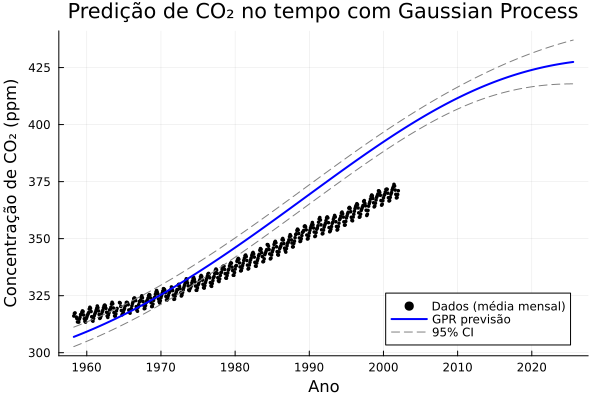

In [2]:
using CSV
using DataFrames
using Dates
using Statistics
using Plots

Plots.gr()  # <- ATIVA o backend GR corretamente

# 1. Carregar dados do CSV
df = CSV.read("mauna-loa.csv", DataFrame)

# 2. Garantir tipos
df.year = Int.(df.year)
df.month = Int.(df.month)
df.day = Int.(df.day)
df.co2 = Float64.(df.co2)

# 3. Criar coluna de datas
df.date = Date.(df.year, df.month, df.day)
df = dropmissing(df)
sort!(df, :date)

# 4. Calcular média mensal
df.monthkey = Date.(year.(df.date), month.(df.date), 1)
df_month = combine(groupby(df, :monthkey), :co2 => mean => :co2_mean)
rename!(df_month, :monthkey => :date)

# 5. FILTRAR datas inválidas
df_month = filter(:date => d -> (d isa Date && year(d) ≥ 1900), df_month)

# 6. Preparar dados
X = Float64.(year.(df_month.date)) .+ (month.(df_month.date) ./ 12)
X = reshape(X, :, 1)
y = df_month.co2_mean
y_mean = mean(y)
y_centered = y .- y_mean

# 7. Predição
today = Dates.today()
xmax = year(today) + month(today) / 12
XPred = reshape(collect(range(minimum(X), xmax, length=500)), :, 1)

# Função GPR já deve estar definida
Xpred_out, ypred_centered, stds = gpr_predict_multidim(X, y_centered; XPred=XPred, plot_result=false)
ypred = ypred_centered .+ y_mean

# 8. Plot
plot(X, y, seriestype=:scatter, label="Dados (média mensal)", color=:black, markersize=2)
plot!(Xpred_out, ypred, lw=2, label="GPR previsão", color=:blue)
plot!(Xpred_out, ypred .+ 2*stds, lw=1, label="95% CI", color=:gray, linestyle=:dash)
plot!(Xpred_out, ypred .- 2*stds, lw=1, label="", color=:gray, linestyle=:dash)
xlabel!("Ano")
ylabel!("Concentração de CO₂ (ppm)")
title!("Predição de CO₂ no tempo com Gaussian Process")
plot!(legend = :bottomright, grid = true)
